#  Filtering in the Frequency Domain

In [27]:
%matplotlib inline
import cv2
import scipy as sc
from scipy import signal
import numpy as np
from matplotlib import pyplot as plt

#  A Recap on the *discrete* 2D Fourier Transform (DFT) and its Inversion



## 2D Fourier Transform

The DFT of a 2D array (matrix / image) is then defined by equation:

$$
F(u,v) = \frac{1}{N_x \cdot N_y} \sum_{x=0}^{N_x - 1}\sum_{y=0}^{N_y - 1}f(x,y) \cdot exp \left[ -j2\pi \cdot \left(\frac{x\cdot u}{N_x} + \frac{y\cdot v}{N_y}  \right) \right]
$$

or

$$
F(u,v) = \frac{1}{N_x \cdot N_y} \sum_{x=0}^{N_x - 1}\sum_{y=0}^{N_x - 1}f(x,y) \cdot exp \left[ -j2\pi \cdot \frac{x\cdot u}{N_x} \right] \cdot exp \left[ -j2\pi \cdot \frac{y\cdot v}{N_y} \right]
$$

-------

## 2D Inverse Fourier Transform

The DFT $F(u,v)$ can be transformed back (inversion) into $f(x,y)$ with this equation:

$$
f(x,y) = \sum_{u'=0}^{N_x - 1}\sum_{v'=0}^{N_y - 1}F(u',v') \cdot exp \left[ j2\pi \cdot \frac{x \cdot u'}{N_x} \right] \cdot exp \left[ j2\pi \cdot \frac{y \cdot v'}{N_y} \right]
$$

-------

# Convolution

$$
g_{conv}(x,y) = \sum_{u=0}^{N_u - 1}\sum_{v=0}^{N_v - 1} f(x-u, y-v) \cdot h(u,v)
$$

## How is convolution related to the discrete Fourier transform ?

From the equation of the inverse 2D Fourier transform an equation for $f(x-u,y-v)$ is obtained:

$$
f(x-u,y-v) = \sum_{u'=0}^{N_x - 1}\sum_{v'=0}^{N_y - 1}F(u',v') \cdot exp \left[ j2\pi \cdot \frac{(x-u)\cdot u'}{N_x} \right] \cdot exp \left[ j2\pi \cdot \frac{(y-v) \cdot v'}{N_y} \right]
$$

This equation can be rearranged into:

$$
f(x-u,y-v) = \sum_{u'=0}^{N_x - 1}\sum_{v'=0}^{N_y - 1}F(u',v') \cdot exp \left[ j2\pi \cdot \frac{
x \cdot u'}{N_x} \right] \cdot exp \left[ j2\pi \cdot \frac{y \cdot v'}{N_y} \right] \cdot exp \left[ j2\pi \cdot \frac{-u \cdot u'}{N_x} \right] \cdot exp \left[ j2\pi \cdot \frac{-v \cdot v'}{N_y} \right]
$$

Inserting $f(x-u,y-v)$ into convolution equation:


$$
g_{conv}(x,y) = \sum_{u'=0}^{N_x - 1}\sum_{v'=0}^{N_y - 1}F(u',v') \cdot exp \left[ j2\pi \cdot \frac{
x \cdot u'}{N_x} \right] \cdot exp \left[ j2\pi \cdot \frac{y \cdot v'}{N_y} \right] \cdot \underbrace{\sum_{u=0}^{N_u - 1}\sum_{v=0}^{N_v - 1} h(u,v) \cdot exp \left[ j2\pi \cdot \frac{-u \cdot u'}{N_x} \right] \cdot exp \left[ j2\pi \cdot \frac{-v \cdot v'}{N_y} \right]}_{H(u',v')} 
$$

Here we observe that $H(u',v')$ is the 2D Fourier transform of the convolution kernel $h(u,v)$:

$$
H(u',v')= \sum_{u=0}^{N_u - 1}\sum_{v=0}^{N_v - 1} h(u,v) \cdot exp \left[ j2\pi \cdot \frac{-u \cdot u'}{N_x} \right] \cdot exp \left[ j2\pi \cdot \frac{-v \cdot v'}{N_y} \right] 
$$

**Note**

$H(u',v')$ is defined for $u', v'$ in the range:

$$
0 \le u' \le N_x -1\\
0 \le v' \le N_y -1
$$

As a consequence the convolution $g_{conv}(x,y)$ can be expressed in a more compact form:

$$
g_{conv}(x,y) = \sum_{u'=0}^{N_x - 1}\sum_{v'=0}^{N_y - 1} \underbrace{F(u',v') \cdot H(u',v')}_{G(u',v')} \cdot exp \left[ j2\pi \cdot \frac{
x \cdot u'}{N_x} \right] \cdot exp \left[ j2\pi \cdot \frac{y \cdot v'}{N_y} \right] 
$$

The product

$$
G(u',v')=F(u',v') \cdot H(u',v')
$$

is identified as the Fourier transform of the convolution $g_{conv}(x,y)$:

$$
g_{conv}(x,y) = \sum_{u'=0}^{N_x - 1}\sum_{v'=0}^{N_y - 1} G(u',v') \cdot exp \left[ j2\pi \cdot \frac{
x \cdot u'}{N_x} \right] \cdot exp \left[ j2\pi \cdot \frac{y \cdot v'}{N_y} \right] 
$$

### Summary

Convolution can be done two ways:

1) directly by evaluating the convolution equation of product terms $f(x-u, y-v) \cdot h(u,v)$ 

2) applying the inverse Fourier transform (IDFT) on the product $G(u',v')=F(u',v') \cdot H(u',v')$ of Fourier transforms.


Some books refer to the process of doing convolution in the frequency domain as *Fourier filtering*.

# Experiments

some experiments show how low-pass filtering affects an image.

The original image is loaded from file and converted into a gray-scale image. All other operation use the gray-scale image.

The Fourier transform of the image is computed. Additionally the magnitude spectrum and the phase spectrum are displayed.

In [34]:
imgFile = "./img/metzgerei_schild_noerdlingen.jpg"
img = cv2.imread(imgFile, cv2.IMREAD_GRAYSCALE)

# the number of rows and columns of this image
# this is used to determine the frequency origin (zero frequency in vertical and horizontal direction)
N_r, N_c = img.shape
N_r_center = N_r // 2
N_c_center = N_c // 2

# 2D Fourier transform
img_fd = np.fft.fft2(img)
# reorder frequencies
img_fd_fshift = np.fft.fftshift(img_fd)
magnitude_spectrum = 20*np.log10(np.abs(img_fd_fshift))
# get phase and map to range [0, 255] ; 0: 0° , 255: 360°
phase_spectrum = 255*(np.angle(img_fd_fshift) + np.pi) / (2*np.pi)

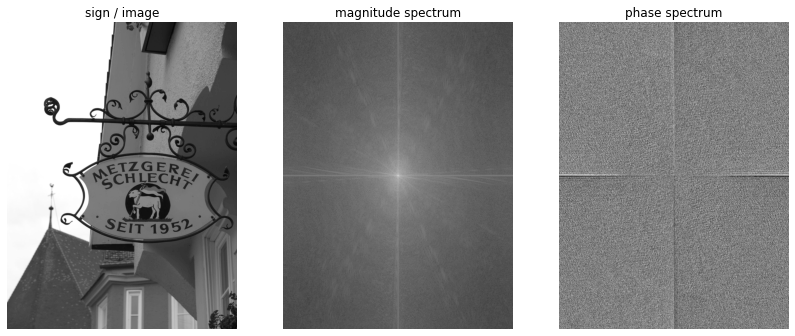

In [35]:
fig1 = plt.figure(1, figsize=[14, 16])

ax_f11 = fig1.add_subplot(1, 3, 1)
ax_f11.imshow(img, cmap='gray')
ax_f11.set_title('sign / image')
ax_f11.axis('off')

ax_f12 = fig1.add_subplot(1, 3, 2)
ax_f12.imshow(magnitude_spectrum, cmap='gray')
ax_f12.set_title('magnitude spectrum')
ax_f12.axis('off')

ax_f13 = fig1.add_subplot(1, 3, 3)
ax_f13.imshow(phase_spectrum, cmap='gray')
ax_f13.set_title('phase spectrum')
ax_f13.axis('off');

## Defining a low-pass filter

The low-pass filter shall be defined in the frequency domain.

The *zero* frequency origing is denoted by parameters `N_r_center` and `N_c_center`. The filter shall pass only frequencies in the range centered around the `N_r_center` and `N_c_center`. Outside this range the Fourier transform of the filter shall be zero.

In [30]:
# low pass filtering
H_filter = np.zeros((N_r, N_c), dtype=np.float64)
# define pass-band of low pass filter by setting frequency response to 1 in 
# a range centered around the frequency origin (0,0)
H_filter[(N_r_center-100):(N_r_center+100), (N_c_center-50):(N_c_center+50)] = 1.0

# apply reordering of frequencies (this is the ordering required 
# for doing filtering in the frequency domain)
H_filter_fshift = np.fft.fftshift(H_filter)

# compute the 2D impulse response of the low pass filter on a log scale;
# before taking the log , add a small number; this avoids warning about log of zero
h_filter_fshift = 20*np.log10(np.abs(np.real(np.fft.ifft2(H_filter_fshift))) +1e-50)

### displaying the low pass filter

1) display filter with centered frequency

2) display filter with fftshift applied; natural frequency order as required for DFT and IDFT

3) display log of impulse response of low pass filter

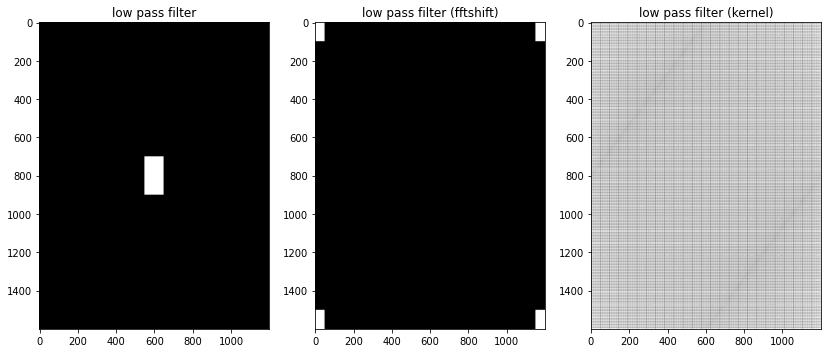

In [31]:
fig2 = plt.figure(2, figsize=[14, 16])

ax_f21 = fig2.add_subplot(1, 3, 1)
ax_f21.imshow(H_filter, cmap='gray')
ax_f21.set_title('low pass filter')

ax_f22 = fig2.add_subplot(1, 3, 2)
ax_f22.imshow(H_filter_fshift, cmap='gray')
ax_f22.set_title('low pass filter (fftshift)')

ax_f23 = fig2.add_subplot(1, 3, 3)
ax_f23.imshow(h_filter_fshift, cmap='gray')
ax_f23.set_title('low pass filter (kernel)');



### Apply low-pass filter to image in the frequency domain

In the frequency domain the filtered image `img_filtered_fd` is just the product of DFT of the original image `img_fd` and transformed kernel `H_filter_fshift`.

The inverse transform yields the filtered image. Due to numerical effects the inverse transformation is generally complex. For the filtered image we are only interested in the real part `img_filtered`.

In [36]:
img_filtered_fd = img_fd * H_filter_fshift

# transforming back into the image domain (ignoring the residual complex part)
img_filtered = np.real(np.fft.ifft2(img_filtered_fd))

### Summary

After filtering some artefacts in the image show the effect of low pass filtering. These artefacts are especially visible along contours / boundary with sudden changes of the brightness.

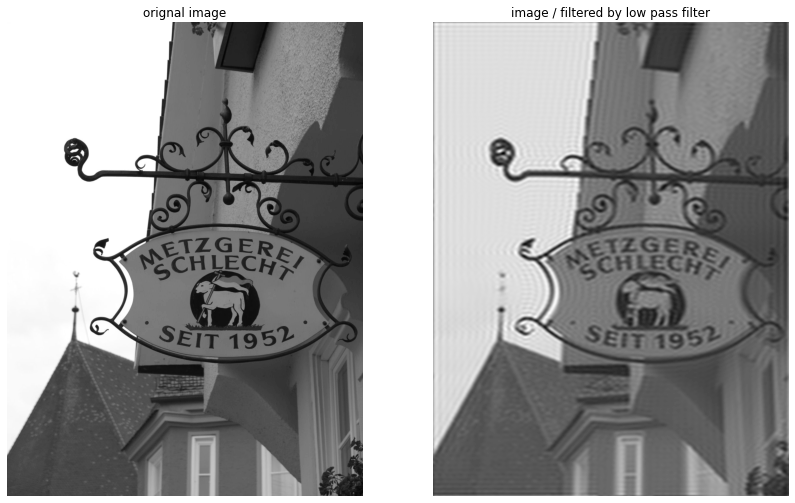

In [37]:
fig3 = plt.figure(3, figsize=[14, 16])

ax_f31 = fig3.add_subplot(1, 2, 1)
ax_f31.imshow(img, cmap='gray')
ax_f31.set_title('orignal image')
ax_f31.axis('off')

ax_f32 = fig3.add_subplot(1, 2, 2)
ax_f32.imshow(img_filtered, cmap='gray')
ax_f32.set_title('image / filtered by low pass filter')
ax_f32.axis('off');